In [9]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import warnings

# Thêm đường dẫn dẫn đến thư mục cha
sys.path.append(os.path.abspath(".."))
warnings.filterwarnings("ignore")

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from utils.landmarks import recalculate_landmarks, draw_landmarks

### 1. Determine important landmarks for lunge

In [4]:
IMPORTANT_LMS = [
    "nose",
    "left_shoulder",
    "right_shoulder",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "left_heel",
    "right_heel",
    "left_foot_index",
    "right_foot_index",
]

In [5]:
def extract_key_points_from_image(
    image_path, label, output_file, is_flip=False, is_draw_landmarks=False
):
    # Khởi tạo MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        static_image_mode=True, model_complexity=1, smooth_landmarks=True
    )

    image = cv2.imread(image_path)
    if is_flip:
        image = cv2.flip(image, 1)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Phát hiện pose
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        if is_draw_landmarks:
            draw_landmarks(mp_drawing, mp_pose, image, results.pose_landmarks)

        # Tính toán lại key points sau khi dịch chuyển phần hông vào giữa
        recalculate_landmarks(results.pose_landmarks.landmark)

        if is_draw_landmarks:
            draw_landmarks(mp_drawing, mp_pose, image, results.pose_landmarks)
            last_dot_index = image_path.rfind(".")
            image_path_output = image_path[:last_dot_index] + "_landmarks" + image_path[last_dot_index:]
            cv2.imwrite(image_path_output, image) # Lưu ảnh đã vẽ landmark

        # Lưu lại toạ độ các key points sau khi dịch chuyển vào csv
        columns_name = ["label"]
        columns_value = [label]
        for id, landmark in enumerate(results.pose_landmarks.landmark):
            land_mark_name = mp_pose.PoseLandmark(id).name.lower()
            if land_mark_name not in IMPORTANT_LMS:
                continue
            columns_name += [
                f"{ land_mark_name }_x",
                f"{ land_mark_name }_y",
                f"{ land_mark_name }_z",
            ]

            # landmark.x, landmark.y là các giá trị trước khi dịch chuyển gốc toạ độ vào giữa bức hình
            # Do đó khi đưa gốc toạ độ về giữa bức hình thì phải trừ chúng cho 0.5
            columns_value += [
                landmark.x - 0.5,
                landmark.y - 0.5,
                landmark.z,
            ]

        df_key_points = pd.DataFrame([columns_value], columns=columns_name)

        with open(output_file, "a") as f:
            # header=f.tell()==0 sẽ ghi tiêu đề nếu file trống
            df_key_points.to_csv(f, header=f.tell() == 0, index=False)
        
    else:
        print(image_path)

    pose.close()

In [39]:
def extract_key_points_from_to_csv(input_folder, folder_type, output_file):
    """
    Extract key points from images are in the input folder to the CSV file
    """
    is_flip = False
    for _ in range(1, 3):
        for image_name in os.listdir(input_folder):
            image_path = os.path.join(input_folder, image_name)
            extract_key_points_from_image(image_path, folder_type, output_file, is_flip)
        is_flip = not is_flip

### 2. Collect data from category folder of plank

In [40]:
folder_qty = 7

In [ ]:
# Collect data from correct folders
for idx in range(1, folder_qty + 1):
    extract_key_points_from_to_csv(
        f"../../Keypoints/data/images/lunge_pose_{idx:02d}_selected/Front", 
        "D", 
        "train.csv"
    )
    print(f"Done folder: {idx}")

In [ ]:
# Collect data from wrong folders
for idx in range(1, folder_qty + 1):
    extract_key_points_from_to_csv(
        f"../../Keypoints/data/images/lunge_pose_{idx:02d}_selected/Middle",
        "M",
        "train.csv",
    )
    print(f"Done folder: {idx}")

In [43]:
# Collect data from correct folders
for idx in range(1, folder_qty + 1):
    extract_key_points_from_to_csv(
        f"../../Keypoints/data/images/lunge_pose_{idx:02d}_selected/Normal", 
        "S", 
        "train.csv"
    )
    print(f"Done folder: {idx}")

Done folder: 1
Done folder: 2
Done folder: 3
Done folder: 4
Done folder: 5
Done folder: 6
Done folder: 7


### 3. Clean the extracted data

In [7]:
def remove_duplicate_row(input_file, output_file):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(input_file)

    # Xoá các hàng trùng lặp
    df_new = df.drop_duplicates()

    # Ghi dữ liệu đã được xử lý vào file CSV mới
    df_new.to_csv(output_file, index=False)

In [ ]:
remove_duplicate_row("train.csv", "train_clean.csv")

In [11]:
plank_df = pd.read_csv("train_clean.csv")

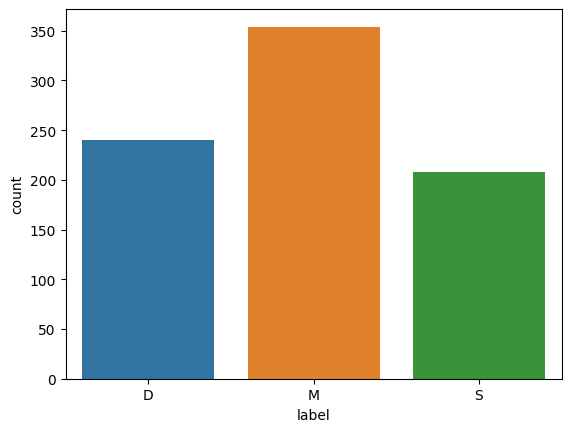

In [12]:
sns.countplot(plank_df, x="label");

### Thử nghiệm dịch chuyển thân người vào giữa với Lunge

In [6]:
extract_key_points_from_image("./Lunge.png", "D", "test.csv", is_draw_landmarks=True)